In [ ]:

import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import logging

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# log 
# record the process of training
logging.basicConfig(
    filename='rovit-10.log',  
    level=logging.INFO,          
    format='%(asctime)s %(message)s',  
)
logger_all = logging.getLogger("logger_all")



In [ ]:



# make single item into a tuple of 2 same items
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# FeedForward network with two fully connected layers and GELU activation
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

# Multi-head self-attention
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        
        # Dimension of concatenated attention heads
        inner_dim = dim_head *  heads
        
        # whether the dimension of the attention's output is same to the expected dimension
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.dim_head = dim_head
        
        # qkv scaling
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        # get attention weight
        self.attend = nn.Softmax(dim = -1)
        
        self.dropout = nn.Dropout(dropout)
        
        # compute qkv at one time
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)
        
        # transfer the dimension of attention's output into expected output dimension
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)
        
        # get q, k, v
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        # get attention weight
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        
        # compute attention out put
        out = torch.matmul(attn, v)
        
        # reshape 
        out = rearrange(out, 'b h n d -> b n (h d)')
        
        # change dimension
        return self.to_out(out)


# ***our modification starts from here***


# Rotational Attention
class RoAttention(Attention):
    def __init__(self, *args, factor, **kwargs):
        super().__init__(*args, **kwargs)
        
        # rotation factor
        self.factor = factor

        self.patch_size = 4
        self.image_size = 32

        # X-axis and Y-axis frequency 
        mag = factor ** (-1 * torch.arange(0, self.dim_head, 4.0) / self.dim_head)
        freqs_x = []
        freqs_y = []
        for i in range(self.heads):
            # Random rotation angles
            angles = torch.rand(1) * 2 * torch.pi
            # frequency in X-axis and Y-axis
            fx = torch.cat([mag * torch.cos(angles), mag * torch.cos(torch.pi/2 + angles)], dim=-1)
            fy = torch.cat([mag * torch.sin(angles), mag * torch.sin(torch.pi/2 + angles)], dim=-1)
            freqs_x.append(fx)
            freqs_y.append(fy)
        freqs_x = torch.stack(freqs_x, dim=0)
        freqs_y = torch.stack(freqs_y, dim=0)
        
        # frequency embeddings require gradient
        self.freqs_x = nn.Parameter(freqs_x, requires_grad=True)
        self.freqs_y = nn.Parameter(freqs_y, requires_grad=True)

        # Positional indices for image patches
        t = torch.arange((self.image_size//self.patch_size)**2, dtype=torch.float32)
        t_x = (t % (self.image_size//self.patch_size)).float()
        t_y = torch.div(t, (self.image_size//self.patch_size), rounding_mode='floor').float()

        # Positional indices do not require gradient
        # self.register_buffer('t_x', t_x)
        # self.register_buffer('t_y', t_y)
        self.t_x = nn.Parameter(t_x, requires_grad=False)
        self.t_y = nn.Parameter(t_y, requires_grad=False)

    # Compute rotational embeddings based on position and frequency
    def rotation(self):
        exp_x = (self.t_x.unsqueeze(-1) @ self.freqs_x.unsqueeze(-2))
        exp_y = (self.t_y.unsqueeze(-1) @ self.freqs_y.unsqueeze(-2))
        rot = torch.polar(torch.ones(exp_x.shape).to(device), exp_x + exp_y)
        return rot

    # convert real to complex representation
    def get_complex(self, x):
        mid = x.float().reshape(*x.shape[:-1], -1, 2)
        comp = torch.view_as_complex(mid)
        return comp
    
    # convert complex to real representation
    def get_real(self, x):
        mid = torch.view_as_real(x)
        real = mid.reshape(*x.shape[:-1], -1)
        return real
    
    # apply rotational embeddings to q and k
    def qk_rot(self, q, k, rot):
        q_comp = self.get_complex(q)
        k_comp = self.get_complex(k)
        rot = rot.reshape(1,*(rot.shape))
        q_out = self.get_real(q_comp * rot)
        k_out = self.get_real(k_comp * rot)
        return q_out, k_out


    def forward(self, x):
        
        x = self.norm(x)
        
        # compute q, k, v
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)
        
        # get rotational embedding
        rot = self.rotation()
        
        # class token's q and k
        additional_q, additional_k = q[:, :, :1, :], k[:, :, :1, :]
        
        # apply rotational embeddings to normal tokens' q and k
        rotated_q, rotated_k = self.qk_rot(q[:, :, 1:, :], k[:, :, 1:, :], rot)

        # combine class token and normal tokens' q and k to get full q and k
        q = torch.cat([additional_q,rotated_q], dim=2)
        k = torch.cat([additional_k,rotated_k], dim=2)

        # get attention weight
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        attn = self.dropout(attn)
        
        # compute attention out put
        out = torch.matmul(attn, v)
        
        # reshape 
        out = rearrange(out, 'b h n d -> b n (h d)')
        
        # change dimension
        return self.to_out(out)


# Transformer using rotational attention
class RoTransformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        
        self.norm = nn.LayerNorm(dim)
        
        # several layers of rotational attention
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                RoAttention(dim, factor=100, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

# Vision Transformer using rotational attention
class RoViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        # layers for transferring patches into token
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        # # positional embedding require gradient
        # self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        # initial class token require gradient
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        
        # rotational transformer
        self.transformer = RoTransformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        
        # Embed image patches into a sequence of tokens
        x = self.to_patch_embedding(img)
        
        b, n, _ = x.shape
        
        # add class token
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        
        # # add positional embedding
        # x += self.pos_embedding[:, :(n + 1)]
        
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        
        # get classification results
        return self.mlp_head(x)   

In [ ]:
# my_rovit = RoViT(
#     image_size = 256,
#     patch_size = 16,
#     num_classes = 100,
#     dim = 512,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 1024,
#     dropout = 0.1,
#     emb_dropout = 0.1
# )


In [ ]:
# a = torch.randn(8,3,256,256)
# b = my_rovit(a)

In [ ]:

# transform image into tensor
transform = transforms.Compose([
    transforms.ToTensor(),  
])

# train dataset and dataloader
# use CIFAR-10
train_batch = 1024
trainset = torchvision.datasets.CIFAR10(root="./cifar-10",
                                         train=True,
                                         download=True,
                                         transform=transform)
# num_worker should be same to the number of CPU core
trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=train_batch, 
    shuffle=True, 
    num_workers=16)

# test dataset and dataloader
# use CIFAR-10
test_batch = train_batch = 2048

testset = torchvision.datasets.CIFAR10(root="./cifar-10",
                                        train=False,
                                        download=True,
                                        transform=transform)
# num_worker should be same to the number of CPU core
testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=test_batch, 
    shuffle=False, 
    num_workers=16)

In [ ]:
# our model
my_rovit = RoViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 100,
    dim = 512,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)

In [ ]:

# Loss function for classification
criterion = nn.CrossEntropyLoss()

lr = 5e-4
optimizer = optim.Adam(my_rovit.parameters(), lr=lr)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    # Set model to training mode
    my_rovit.train() 
    
    # running loss for each epoch
    running_loss = 0.0
    
    # counter of processed items for each epoch 
    cnt = 0
    
    for i, (images, labels) in enumerate(trainloader):
        
        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # classification result
        outputs = my_rovit(images)
        
        # loss
        loss = criterion(outputs, labels)

        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # count running loss and processed items
        running_loss += loss.item()
        b = images.shape[0]
        cnt += b
        
        # log message for each iteration
        msg = f'Epoch [{epoch + 1}/{num_epochs}], Item [{cnt}/{len(trainset)}], Loss: {running_loss / (i+1):.4f}'
        logger_all.info(msg)
        print(msg)
        
    # log message for each epoch
    msg = f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}'
    logger_all.info(msg)
    print(msg)

    # save checkpoint
    if (epoch + 1)%5==0:
        model_save_path = f'./ckpt/rovit-10/rovit_{epoch+1}.pth'
        torch.save(my_rovit.state_dict(), model_save_path)
        print(f'Model parameters saved to {model_save_path}')

model_save_path = f'./ckpt/rovit-10/rovit_last.pth'
torch.save(my_rovit.state_dict(), model_save_path)
print(f'Model parameters saved to {model_save_path}')

In [ ]:

# my_rovit.eval() 
# correct = 0
# total = 0
# 
# with torch.no_grad():
#     for images, labels in testloader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = my_rovit(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# 
# accuracy = 100 * correct / total
# print(f'Accuracy on CIFAR-10 test images: {accuracy:.2f}%')

In [ ]:
# my_rovit = RoViT(
#     image_size = 32,
#     patch_size = 4,
#     num_classes = 100,
#     dim = 512,
#     depth = 6,
#     heads = 16,
#     mlp_dim = 1024,
#     dropout = 0.1,
#     emb_dropout = 0.1
# ).to(device)
# model_save_path = './ckpt/rovit-10/rovit_50.pth'
# my_rovit.load_state_dict(torch.load(model_save_path))
# my_rovit = my_rovit.to(device)
# my_rovit.eval()  
# print("Model loaded and ready for inference.")

In [ ]:
# a = torch.randn(8,3,256,256).to(device)
# b = my_rovit(a)

In [ ]:

# my_rovit.eval()  
# correct = 0
# total = 0
# 
# with torch.no_grad():
#     for images, labels in testloader:
#         images = images.to(device)
#         labels = labels.to(device)
#         outputs = my_rovit(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
# 
# accuracy = 100 * correct / total
# print(f'Accuracy on CIFAR-10 test images: {accuracy:.2f}%')

In [ ]:
res = []

In [ ]:
# Evaluation for models at different epoches
for e in range(5,155,5):
    my_vit = RoViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 100,
    dim = 512,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
    
    # load checkpoint
    model_save_path = f'./ckpt/rovit-10/rovit_{e}.pth'
    my_vit.load_state_dict(torch.load(model_save_path))
    
    # mode model to GPU
    my_vit = my_vit.to(device)
    
    # Set model to evaluation mode
    my_vit.eval() 

    # Accuracy calculation
    # counter for test
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in testloader:
            
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # classification results
            outputs = my_vit(images)
            
            # predicted class label
            _, predicted = torch.max(outputs.data, 1)
            
            # update counters
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # get test result for an epoch
    accuracy = 100 * correct / total
    res.append(accuracy)

In [ ]:
print(res)

In [2]:
vit10 = [62.19, 64.78, 64.33, 65.27, 65.65, 64.82, 66.27, 66.09, 65.97, 66.74, 66.86, 66.58, 66.87, 67.29, 67.07, 66.9, 67.48, 67.3, 67.51, 67.85, 67.71, 67.03, 67.48, 68.44, 67.76, 67.59, 67.99, 68.53, 67.64, 67.68]

print(len(vit10))


30


In [3]:
rovit10 = [65.44, 66.95, 67.6, 67.72, 68.21, 67.79, 68.12, 68.49, 69.4, 69.22, 69.08, 69.1, 69.84, 69.27, 69.95, 69.97, 69.79, 69.58, 69.75, 70.17, 69.89, 70.69, 69.86, 70.61, 70.99, 70.85, 69.97, 70.6, 70.13, 70.81]

print(len(rovit10))

30


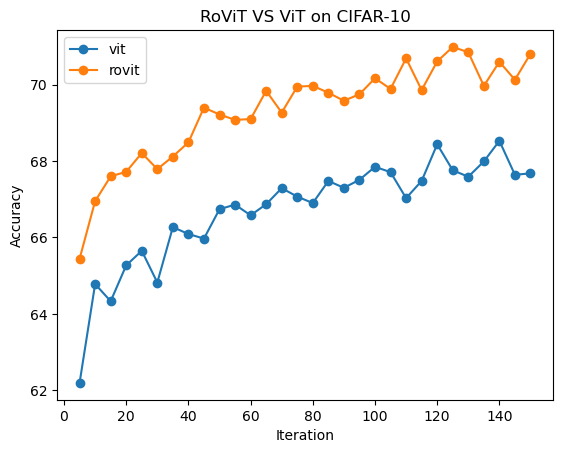

In [4]:
import matplotlib.pyplot as plt

# X-axis
x = range(5,155,5)

# plot ViT and our RoViT
plt.plot(x, vit10, label='vit', marker='o')
plt.plot(x, rovit10, label='rovit', marker='o')

plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("RoViT VS ViT on CIFAR-10")
plt.legend()

plt.show()

In [ ]:
from thop import profile
model = RoViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 10,
    dim = 512,
    depth = 6,
    heads = 16,
    mlp_dim = 1024,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)
x = torch.randn(1, 3, 32, 32).to(device)
# macs, params = profile(model, inputs=(input, ))
flops, params = profile(model, inputs=(x,))
print('FLOPs = ' + str(flops/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')